# Lab Session 2: Longitudinal Behavioral Analysis & Mental Health (LMM)

In this session, we will bridge the gap between high-frequency digital traces and psychological well-being. Building on today's lecture, we will analyze how web browsing patterns correlate with **Loneliness (UCLA-3)** and **Stress (PSS-10)** using a dataset covering 50 individuals over 6 months.

To account for the **longitudinal and nested structure** of this data (repeated observations within individuals), we will implement **Linear Mixed-Effects Models (LMM)**.

### Learning Objectives
By the end of this session, you will be able to:
* **Perform Multi-Granular Data Alignment**: Learn strategies to merge datasets with different temporal resolutions (e.g., millisecond-level logs vs. monthly surveys).
* **Execute Feature Engineering**: Calculate advanced behavioral features such as diurnal activity patterns (Day vs. Night) and category-specific engagement.
* **Implement Mixed-Effects Modeling**: Understand the practical distinction between **Fixed Effects** (population-level trends) and **Random Effects** (individual variations).


### Pre-reading & Resources on LMM
If you need a refresher on Linear Mixed Models, please refer to:
* **The "Plain English" Guide**: [Introduction to Mixed Effects Models](https://ourcodingclub.github.io/tutorials/mixed-models/) (Coding Club)
* **The Academic Reference**: Meteyard, L., & Davies, R. A. (2020). [Best practice guidance for linear mixed-effects models in psychological science](https://pmc.ncbi.nlm.nih.gov/articles/PMC7153721/). *Journal of Memory and Language*.
* **Documentation**: [Statsmodels LMM Overview](https://www.statsmodels.org/stable/mixed_linear.html) - *Technical documentation for the library we will use today.*

## Programming Toolkit

To perform this analysis, we will use several specialized Python libraries. You can refer to the official documentation for detailed API information:

| Library | Category | Purpose | Documentation |
| :--- | :--- | :--- | :--- |
| **Pandas** | Data Manipulation | Handling dataframes, time-series alignment, and merging. | [Link](https://pandas.pydata.org/docs/) |
| **NumPy** | Numerical Computing | Vectorized operations and mathematical functions. | [Link](https://numpy.org/doc/) |
| **Statsmodels** | Statistical Modeling | Implementing Linear Mixed-Effects Models (LMM) and summary stats. | [Link](https://www.statsmodels.org/stable/index.html) |
| **Seaborn** | Data Visualization | High-level interface for drawing attractive statistical graphics. | [Link](https://seaborn.pydata.org/) |
| **Matplotlib** | Plotting Engine | Base library for fine-tuning plot aesthetics and layouts. | [Link](https://matplotlib.org/stable/index.html) |
| **Scipy** | Scientific Computing | Used for statistical tests and probability distributions. | [Link](https://docs.scipy.org/doc/scipy/) |

>Run the code cell below to initialize your environment.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings

# Suppress warnings for cleaner output during the lab
warnings.filterwarnings('ignore')

# --- Visualization Settings ---
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

## 2. Data Acquisition & Structural Overview

In this session, we work with four datasets. Our goal is to align these into a single "longitudinal" dataframe ready for modeling.

### 2.1 Dataset Descriptions

| Dataset | Granularity | Key Columns | Description |
| :--- | :--- | :--- | :--- |
| **Browsing Logs** | High-frequency | `pid`, `url`, `used_at`,`domain`, `duration`, `wave` | Raw web traces recording every URL visited. |
| **Surveys** | Monthly (6 waves) | `pid`, `wave`, `ucla_3`, `pss_10` | Repeated mental health assessments. |
| **Demographics** | Static | `pid`, `gender`, `age_group` | Constant user characteristics. |
| **Domain Map** | Metadata | `domain`, `category` | Mapping URLs to functional categories (e.g., Social, News). |

### 2.2 Variables of Interest

#### **Mental Health Indicators (Dependent Variables)**
* **UCLA-3 (Loneliness)**: A 3-item scale measuring feelings of social isolation.
    * **Range**: 3 to 9. Higher scores indicate **greater loneliness**.
* **PSS-10 (Perceived Stress)**: A 10-item scale measuring the degree to which situations in life are appraised as stressful.
    * **Range**: 0 to 40. Higher scores indicate **higher perceived stress**.

#### **Demographic Coding**
* **Gender**: `1` = Male, `0` = Female.
* **Age Group**:
    * `1`: 18 – 30 years old
    * `2`: 31 – 60 years old
    * `3`: 60+ years old


In [2]:
# --- Data Loading ---
BASE_URL = "https://raw.githubusercontent.com/Yajing-W/CSS_winterschool_practice/refs/heads/main/"

# Task 2: Load the datasets from the remote repository
try:
    df_logs = pd.read_parquet(BASE_URL + "browsing_traces_50.parquet")
    df_survey = pd.read_csv(BASE_URL + "surveys.csv")
    df_demo = pd.read_csv(BASE_URL + "demographics_50.csv")
    df_domain_map = pd.read_csv(BASE_URL + "domain_category_map.csv")

    print("All datasets loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

# --- Data Inspection ---
# We print the shapes and preview the demographic and log data
print(f"\n[Summary Statistics]")
print(f"- Browser Logs: {df_logs.shape[0]} records")
print(f"- Survey Responses: {df_survey.shape[0]} records")
print(f"- Demographic Profiles: {df_demo.shape[0]} users")

print(f"\n[Preview: Demographics (df_demo)]")
display(df_demo.head())

print(f"\n[Preview: Browser Logs (df_logs)]")
display(df_logs.head())

All datasets loaded successfully.

[Summary Statistics]
- Browser Logs: 5519315 records
- Survey Responses: 293 records
- Demographic Profiles: 50 users

[Preview: Demographics (df_demo)]


,pid,gender,age_group
0,17928178433648,1,3
1,17928333266704,0,3
2,17928233392272,1,2
3,17928116278800,1,2
4,17928195102720,1,3



[Preview: Browser Logs (df_logs)]


,pid,url,used_at,duration,domain,wave
0,17928019680592,ltw.panelsupport.info/4465162,2023-06-15 14:13:36,16.0,panelsupport.info,1
1,17928019680592,slither.io/6955690,2023-06-15 14:14:05,1141.0,slither.io,1
2,17928019680592,ltw.panelsupport.info/4465143,2023-06-15 14:37:20,1.0,panelsupport.info,1
3,17928019680592,ltw.panelsupport.info/4465143,2023-06-15 14:37:23,3.0,panelsupport.info,1
4,17928019680592,slither.io/6955690,2023-06-15 14:37:27,291.0,slither.io,1


## 3.1 Feature Engineering: Defining Behavioral Markers

To test our hypotheses regarding mental health, we need to convert raw timestamped logs into meaningful behavioral indicators. For each user (`pid`) within each measurement period (`wave`), we will extract the following features:

| Feature | Definition | Behavioral Significance |
| :--- | :--- | :--- |
| **Total_Duration** | Total monthly online hours. | Overall digital engagement/sedentary behavior. |
| **Day_Night_Diff** | (Duration 06:00-18:00) - (Duration 18:00-06:00). | Measures **Circadian Shift**. Negative values indicate high nocturnal activity, often linked to sleep disruption and stress. |
| **Category_Hours** | Total hours spent on 'Social Media', 'Games', and 'Shopping'. | Distinguishes between active communication, entertainment-seeking, and impulsive behaviors. |



> **Note on Scaling**: We convert the raw `duration` (seconds) into **Hours** to ensure our regression coefficients ($\beta$) are interpretable (e.g., "an increase of 1 hour is associated with X points of stress").

> **Task**: Calculate these features and aggregate them at the `(pid, wave)` level.

In [3]:
# Task 3.1: Extract behavioral features from browser logs

# 1. Domain-Category Mapping
# We merge logs with the domain map to identify the type of activity
df_logs_mapped = pd.merge(df_logs, df_domain_map, on='domain', how='left')

# 2. Handling Missing Categories
# Assign 'uncategorized' to any domain not found in our mapping table
df_logs_mapped['category'] = df_logs_mapped['category'].fillna('uncategorized')

# 3. Temporal Processing
# Ensure datetime format and define Day/Night
df_logs_mapped['used_at'] = pd.to_datetime(df_logs_mapped['used_at'])
df_logs_mapped['hour'] = df_logs_mapped['used_at'].dt.hour
df_logs_mapped['is_daytime'] = df_logs_mapped['hour'].between(6, 17) # Day: 06:00-17:59

# 4. Aggregating Features per (PID, Wave)
# Convert seconds to hours for better scale in modeling
total_dur = df_logs_mapped.groupby(['pid', 'wave'])['duration'].sum() / 3600

# Day-Night Duration Difference
day_night = df_logs_mapped.pivot_table(index=['pid', 'wave'],
                                       columns='is_daytime',
                                       values='duration',
                                       aggfunc='sum',
                                       fill_value=0) / 3600
day_night_diff = day_night.get(True, 0) - day_night.get(False, 0)

# 5. Extracting Specific Categories
# We group by pid/wave/category and pivot to get hours per category
cat_hours = df_logs_mapped.groupby(['pid', 'wave', 'category'])['duration'].sum().unstack(fill_value=0) / 3600

# 6. Construct Feature Dataframe
df_features = pd.DataFrame({
    'total_duration': total_dur,
    'day_night_diff': day_night_diff,
    'social_media_duration': cat_hours.get('social_media', 0),
    'games_duration': cat_hours.get('games', 0),
    'shopping_duration': cat_hours.get('shopping', 0)
}).reset_index()

print("Behavioral features extracted and 'uncategorized' labels assigned.")
display(df_features.head())

Behavioral features extracted and 'uncategorized' labels assigned.


,pid,wave,total_duration,day_night_diff,social_media_duration,games_duration,shopping_duration
0,17928019680592,1,196.677778,-33.125556,27.461667,0.008889,5.747500
1,17928019680592,2,189.472500,-4.060833,11.130278,0.001111,6.367500
2,17928019680592,3,237.709722,-1.972500,13.552778,0.000000,8.202222
3,17928019680592,4,228.128889,-78.641111,23.834722,0.005556,4.030556
4,17928019680592,5,276.637778,-42.155000,34.793056,0.006667,4.869444


## 3.2 Data Integration: Building the Longitudinal Dataset

Now that we have extracted behavioral markers from raw logs, we must align them with our "Ground Truth" labels (Survey scores) and user characteristics (Demographics).

### The Merging Logic
To perform a **Linear Mixed-Effects (LMM)** analysis, our data must be in **Long Format**. This means:
1.  **Time-Varying Data**: Behavioral features and Survey scores are matched by both User ID (`pid`) and Time (`wave`).
2.  **Static Data**: Demographic info (Gender, Age) is matched only by User ID (`pid`) and is repeated for every wave of that user.



### Handling Missingness
Unlike traditional OLS or ANOVA, LMM does not require every participant to have data for every single wave.
However, we still need to ensure that for any given "User-Wave" observation, we have both the predictor (behavior) and the outcome (survey score).
* We use an **Inner Join** between surveys and behavior to ensure our model only trains on complete observations (Timepoints where we have both a behavioral "predictor" and a mental health "outcome").

> **Task**:
> 1. Check for missing values in the survey dataset.
> 2. Consolidate the data into a single long-format dataframe `df_final`.

In [4]:
# --- 1. Check for missing values in Survey data ---
print("Checking for missing values in Surveys:")
print(df_survey[['ucla_3', 'pss_10']].isnull().sum())

# --- 2. Merge Behavioral Features with Surveys ---
# We use 'inner' join here because a model needs both X (behavior) and Y (survey)
# for a specific time point to calculate the residual.
df_final = pd.merge(df_survey, df_features, on=['pid', 'wave'], how='inner')

# --- 3. Merge with Demographics ---
df_final = pd.merge(df_final, df_demo, on='pid', how='left')

# --- 4. Verify Data Retainment ---
n_original_users = df_survey['pid'].nunique()
n_final_users = df_final['pid'].nunique()
print(f"\nOriginally: {n_original_users} users.")
print(f"After merging: {n_final_users} users retained.")
print(f"Total User-Wave observations for LMM: {len(df_final)}")

# Sort for longitudinal structure
df_final = df_final.sort_values(['pid', 'wave']).reset_index(drop=True)
display(df_final.head())

Checking for missing values in Surveys:
ucla_3    0
pss_10    0
dtype: int64

Originally: 50 users.
After merging: 50 users retained.
Total User-Wave observations for LMM: 293


,pid,wave,ucla_3,pss_10,total_duration,day_night_diff,social_media_duration,games_duration,shopping_duration,gender,age_group
0,17928019680592,1,3.7,40.0,196.677778,-33.125556,27.461667,0.008889,5.747500,1,1
1,17928019680592,2,3.0,28.3,189.472500,-4.060833,11.130278,0.001111,6.367500,1,1
2,17928019680592,3,3.4,29.9,237.709722,-1.972500,13.552778,0.000000,8.202222,1,1
3,17928019680592,4,4.4,40.0,228.128889,-78.641111,23.834722,0.005556,4.030556,1,1
4,17928019680592,5,3.9,40.0,276.637778,-42.155000,34.793056,0.006667,4.869444,1,1


## 4. Pre-modeling Diagnostics

Before fitting our Linear Mixed-Effects Models (LMM), we must evaluate the relationships between our predictors.

### 4.1 Multicollinearity: Correlation & VIF
In behavioral research, different metrics often carry redundant information. We use two complementary tools to detect **Multicollinearity**:
1.  **Correlation Matrix (Qualitative)**: A heatmap showing pairwise relationships. We look for coefficients $|r| > 0.7$.
2.  **Variance Inflation Factor (VIF, Quantitative)**: Measures how much a variable is explained by *all other* predictors combined.
    * **VIF < 5**: Generally acceptable.
    * **VIF > 10**: Indicates high multicollinearity; the variable may need to be removed to ensure model stability.

### 4.2 Categorical Factor Conversion
We ensure `gender` and `age_group` are treated as **factors**. This allows the model to estimate differences between groups (e.g., comparing Age Group 1 vs. Group 2) rather than treating them as continuous numbers.

> **Task**:
> 1. Compute and visualize the correlation matrix for behavioral features.
> 2. Calculate the VIF for our behavioral markers.
> 3. Convert demographic variables into the proper categorical format.

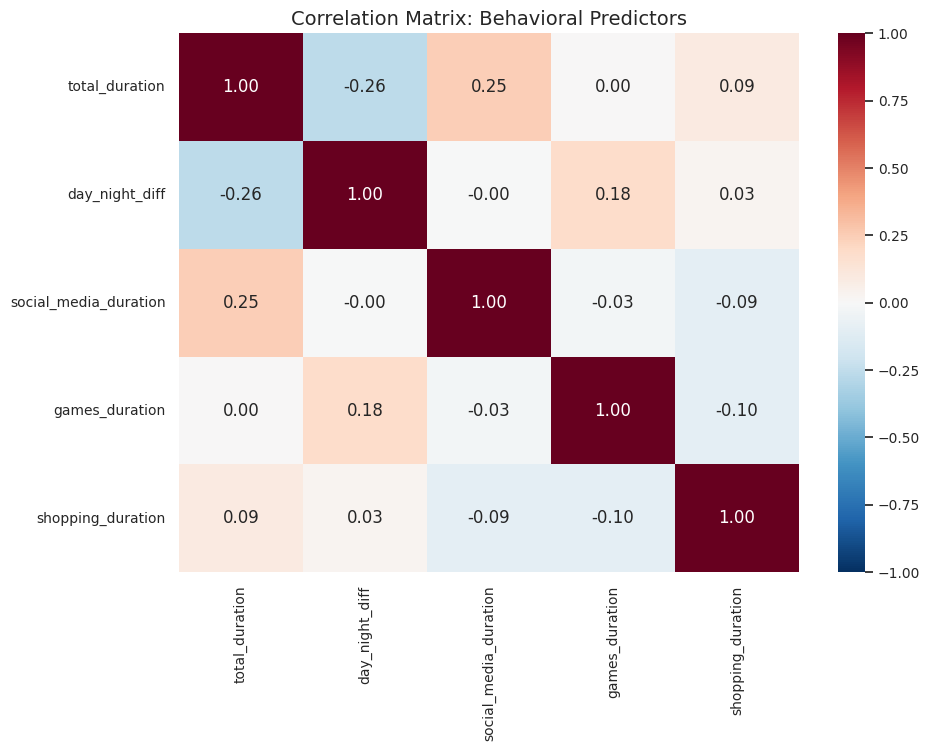


[VIF Diagnostics Table]


,Feature,VIF
0,total_duration,1.17
1,day_night_diff,1.13
2,social_media_duration,1.09
3,games_duration,1.05
4,shopping_duration,1.04



[Descriptive Statistics: Behavioral Metrics (Hours)]


,total_duration,day_night_diff,social_media_duration,games_duration,shopping_duration
count,293.00,293.00,293.00,293.00,293.00
mean,180.97,14.92,47.49,11.18,11.55
std,89.49,54.58,46.43,24.24,16.78
min,18.62,-176.28,0.00,0.00,0.00
25%,132.12,-20.23,7.28,0.00,2.05
50%,164.57,17.65,34.79,0.00,7.11
75%,216.71,53.50,77.08,9.60,14.89
max,583.55,123.00,231.23,157.36,196.63



- Successfully converted 'gender' levels: [1, 0]
- Successfully converted 'age_group' levels: [1, 3, 2]


In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Variable Selection
behavioral_cols = [
    'total_duration', 'day_night_diff', 'social_media_duration',
    'games_duration', 'shopping_duration'
]

# 2. Part A: Categorical Factor Conversion
# We create df_model here to ensure all subsequent diagnostics use the same object
df_model = df_final.copy()
df_model['gender'] = df_model['gender'].astype('category')
df_model['age_group'] = df_model['age_group'].astype('category')

# 3. Part B: Correlation Heatmap (Qualitative Check)
plt.figure(figsize=(10, 7))
corr_matrix = df_model[behavioral_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix: Behavioral Predictors")
plt.show()

# 4. Part C: VIF Calculation (Quantitative Check)
# We add a constant as VIF requires an intercept to be mathematically sound
X_vif = df_model[behavioral_cols].assign(const=1)

vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\n[VIF Diagnostics Table]")
# We exclude the 'const' row for the final display
display(vif_df[vif_df['Feature'] != 'const'].round(2).sort_values(by="VIF", ascending=False))

# 5. Final Data Integrity Check
print("\n[Descriptive Statistics: Behavioral Metrics (Hours)]")
display(df_model[behavioral_cols].describe().round(2))

print(f"\n- Successfully converted 'gender' levels: {df_model['gender'].unique().tolist()}")
print(f"- Successfully converted 'age_group' levels: {df_model['age_group'].unique().tolist()}")

### 4.3 Feature Transformation: To Scale or Not to Scale?

In this lab, we have chosen to keep our behavioral predictors in their **raw units (hours)** to ensure that our coefficients ($\beta$) have a direct physical interpretation (e.g., "one extra hour of gaming leads to $X$ points change in stress"). However, this choice involves a trade-off regarding **Model Convergence**.

Unlike simple OLS regression, LMMs are estimated using iterative numerical algorithms (such as **Restricted Maximum Likelihood - REML**). The algorithm "searches" for the best parameters that maximize the likelihood of the data.
* **The Convergence Risk**: If our predictors have vastly different scales (e.g., one variable ranges from 0.1 to 1.0, while another ranges from 10 to 500), the optimization surface becomes very "steep" in some directions and "flat" in others. This can cause the algorithm to fail, resulting in a **"Convergence Warning"** or a **"Singular Fit"**.
* **Standardization as a Solution**: Standardizing variables (Z-score) ensures all predictors have a mean of 0 and a standard deviation of 1. This "round" optimization space makes it much easier for the algorithm to reach the global optimum.

> **Instruction**: We will proceed with raw hours. If you encounter a `ConvergenceWarning` or `Singular Matrix` error in the next step, the first troubleshooting step should be returning here to standardize your features.

## 5. Linear Mixed-Effects Modeling (LMM)

In this section, we move beyond simple correlation to **statistical modeling**. Our data has a nested structure: multiple observations (Waves) are clustered within individuals (`pid`).

### 5.1 Why use LMM?
A standard linear regression (OLS) assumes all observations are independent. However, a person's loneliness score at Wave 2 is likely related to their score at Wave 1. LMM accounts for this by splitting the model into:
1.  **Fixed Effects**: The average relationship between digital behavior and mental health across the whole population.
2.  **Random Effects**: The individual "baseline" differences. Some people are naturally more lonely or stressed than others.

### 5.2 Model Specification
We use the following formula for both models:
$$MentalHealth_{ij} = (\beta_0 + u_i) + \beta_1(Behavior_{ij}) + \beta_2(Demographics_i) + \epsilon_{ij}$$

Where:
* $u_i$ is the **Random Intercept** for person $i$ (capturing individual stability).
* $\beta$ are the **Fixed Effects** (the universal trends we want to discover).


---

## 5.3 Task A: Modeling Loneliness (UCLA-3)

**Hypothesis**: High loneliness is associated with high Social Media use.

In this step, we evaluate not just the coefficients, but also the **Model Performance**:
* **ICC (Intraclass Correlation Coefficient)**: Proportion of variance explained by individual differences.
> ***Rule of Thumb**: If **$ICC > 0.05$**, it indicates that the nested structure of the data is significant, and using an LMM is mandatory to avoid biased results.*
* **Marginal $R^2$**: Variance explained by our behavioral predictors (Fixed Effects).
* **Conditional $R^2$**: Total variance explained by the entire model (Fixed + Random Effects).

> **Task**: Fit the Loneliness model and calculate the ICC to justify the use of Mixed Effects.

In [6]:
import statsmodels.formula.api as smf

# 1. Define Formula (Social Media is our focus, others are controls)
formula_ucla = "ucla_3 ~ social_media_duration + total_duration + day_night_diff + " \
               "games_duration + shopping_duration + gender + age_group"

# 2. Fit the Model
model_ucla = smf.mixedlm(formula_ucla, df_model, groups=df_model["pid"]).fit()

# 3. Calculate Variance Components & ICC
# Variance due to individual intercepts (Random Effect)
var_random = model_ucla.cov_re.iloc[0, 0]
# Variance due to residuals (Unexplained)
var_resid = model_ucla.scale
# ICC = Random / (Random + Residual)
icc = var_random / (var_random + var_resid)

# 4. Display Summary & Metrics
print(model_ucla.summary())
print(f"\n" + "-"*30)
print(f"MODEL DIAGNOSTICS:")
print(f"Intraclass Correlation (ICC): {icc:.4f}")
print(f" - Interpretation: {icc*100:.1f}% of loneliness variance is at the individual level.")
print("-"*30)

# 5. Interpretation of the Core Hypothesis
p_val = model_ucla.pvalues['social_media_duration']
if p_val < 0.05:
    print(f"Hypothesis Supported: Social Media duration is a significant predictor (p={p_val:.4f}).")
else:
    print(f"Hypothesis Not Supported: Social Media duration is not significant (p={p_val:.4f}).")

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    ucla_3   
No. Observations:    293        Method:                REML     
No. Groups:          50         Scale:                 0.6909   
Min. group size:     4          Log-Likelihood:        -475.4300
Max. group size:     6          Converged:             Yes      
Mean group size:     5.9                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              6.884    0.799  8.615 0.000  5.318  8.450
gender[T.1]            0.121    0.707  0.171 0.864 -1.264  1.505
age_group[T.2]        -0.689    0.804 -0.857 0.392 -2.265  0.887
age_group[T.3]        -1.388    0.822 -1.689 0.091 -2.999  0.223
social_media_duration  0.009    0.003  3.283 0.001  0.004  0.014
total_duration         0.001    0.001  

## 5.4 Task B: Modeling Stress (PSS-10) with Subgroup Analysis

In this section, we test specific hypotheses regarding Stress by comparing different demographic groups. Subgroup analysis allows us to observe how behavioral predictors vary between men and women.

### Hypotheses:
1.  **H1 (Circadian & Gaming)**: Across all users, higher stress is associated with lower `day_night_diff` (nighttime activity) and higher `games_duration`.
2.  **H2 (Gendered Comparison)**: The association between `shopping_duration` and stress is primarily driven by the female subgroup.

> **Task**:
> 1. Fit an LMM for the Full Sample to test H1.
> 2. Split the data by gender and fit separate LMMs to compare the impact of shopping (H2).

In [9]:
# 1. Full Sample Model (Testing H1)
formula_pss_full = "pss_10 ~ day_night_diff + shopping_duration + games_duration + social_media_duration + total_duration + gender + age_group"
model_pss_full = smf.mixedlm(formula_pss_full, df_model, groups=df_model["pid"]).fit()

# Calculate ICC for Full Sample
icc_full = model_pss_full.cov_re.iloc[0,0] / (model_pss_full.cov_re.iloc[0,0] + model_pss_full.scale)

print(model_pss_full.summary())
print(f"\nFull Sample ICC: {icc_full:.4f}")

# 2. Subgroup Analysis (Testing H2)
# Gender: 1 = Male, 0 = Female.
df_male = df_model[df_model['gender'] == 1]
df_female = df_model[df_model['gender'] == 0]
# Define common formula for subgroups (no 'gender' as a predictor here)
formula_sub =  "pss_10 ~ day_night_diff + shopping_duration + games_duration + social_media_duration + total_duration + age_group"
# --- SUBGROUP: MALE ---
print("\n" + "="*30 + " SUBGROUP: MALE " + "="*30)
model_male = smf.mixedlm(formula_sub, df_male, groups=df_male["pid"]).fit()
icc_male = model_male.cov_re.iloc[0,0] / (model_male.cov_re.iloc[0,0] + model_male.scale)

print(model_male.summary())
print(f"Male Subgroup ICC: {icc_male:.4f}")

# --- SUBGROUP: FEMALE ---

print("\n" + "="*30 + " SUBGROUP: FEMALE " + "="*30)
model_female = smf.mixedlm(formula_sub, df_female, groups=df_female["pid"]).fit()
icc_female = model_female.cov_re.iloc[0,0] / (model_female.cov_re.iloc[0,0] + model_female.scale)

print(model_female.summary())
print(f"Female Subgroup ICC: {icc_female:.4f}")

# 3. Final Comparison for Shopping
print("\n" + "HYPOTHESIS H2 CHECK: Shopping Impact on Stress")
print(f"Male Shopping Beta:   {model_male.params['shopping_duration']:.4f} (p={model_male.pvalues['shopping_duration']:.4f})")
print(f"Female Shopping Beta: {model_female.params['shopping_duration']:.4f} (p={model_female.pvalues['shopping_duration']:.4f})")

              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    pss_10   
No. Observations:      293        Method:                REML     
No. Groups:            50         Scale:                 27.8543  
Min. group size:       4          Log-Likelihood:        -984.6238
Max. group size:       6          Converged:             Yes      
Mean group size:       5.9                                        
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept              17.767    3.641   4.880 0.000 10.632 24.903
gender[T.1]            -0.934    3.185  -0.293 0.769 -7.176  5.309
age_group[T.2]          1.988    3.615   0.550 0.582 -5.097  9.074
age_group[T.3]          3.305    3.697   0.894 0.371 -3.942 10.552
day_night_diff         -0.205    0.014 -14.847 0.000 -0.232 -0.178
shopping_d

## 6. Visualizing Model Findings: Effect Size Comparison

In the final step of our analysis, we will visualize the **Fixed Effects** from our LMMs. This visualization helps us answer the core research questions:
1.  Which digital behavior is the strongest predictor of **Loneliness** or **Stress**?

### Interpreting the Plot
* **X-axis (Coefficient)**: Represents the change in mental health score for every **1-hour increase** in behavior.
* **Positive Values**: The behavior is associated with *increased* loneliness/stress.
* **Vertical Line at 0**: If the error bar crosses this line, the effect is likely not statistically significant.

> **Task**: Create a comparative bar chart showing coefficients for all models.

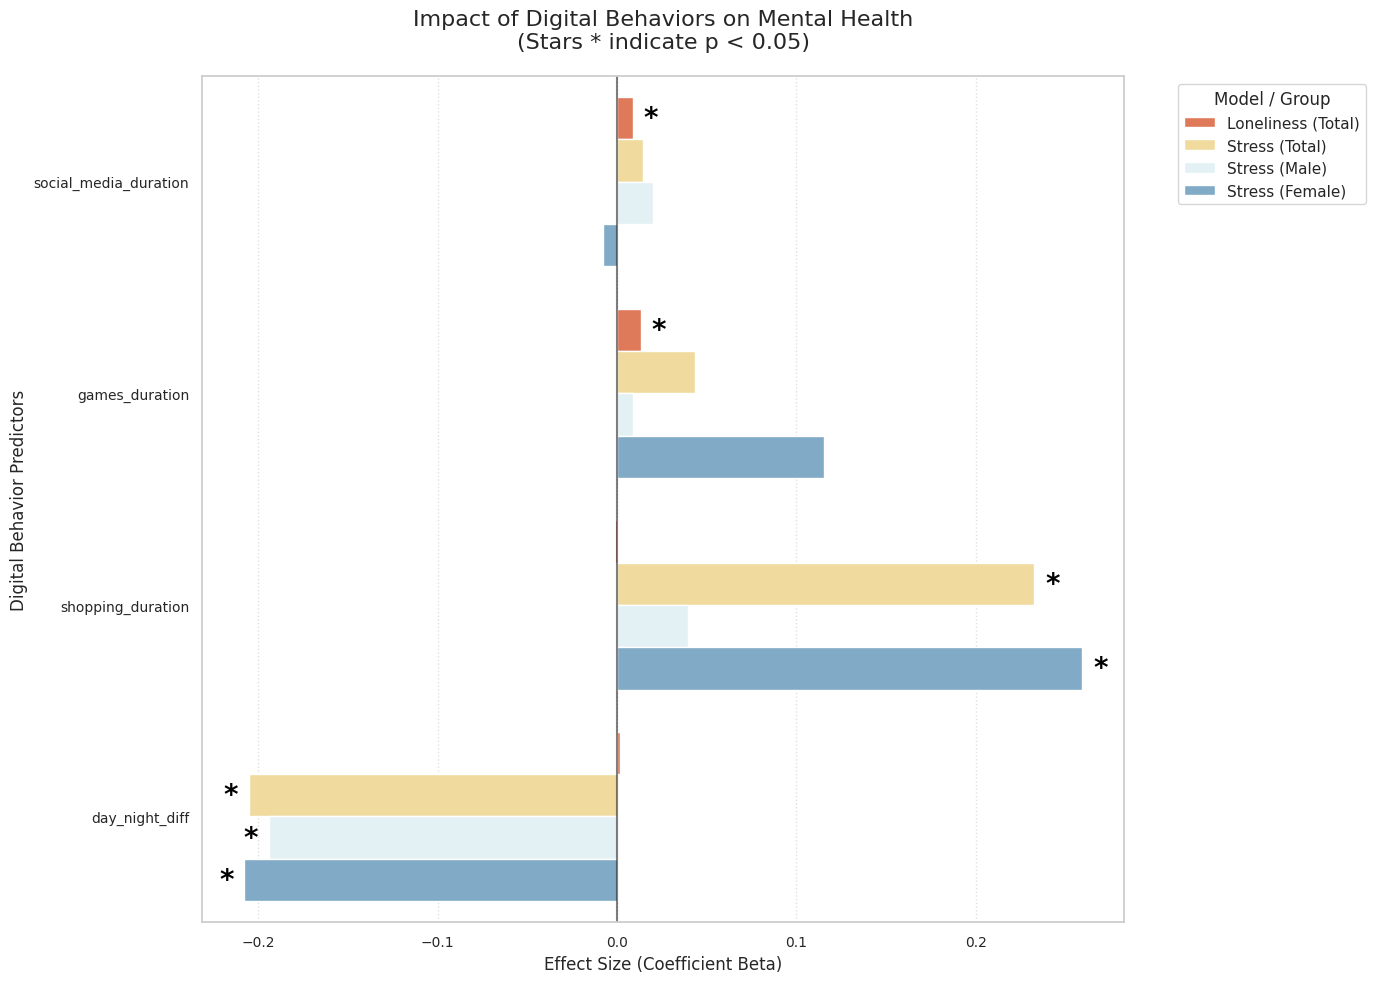

--- Post-Analysis Discussion Guide ---
1. SIGNIFICANCE: Focus on bars with stars (*). If there is no star, the effect is not statistically reliable.
2. DIRECTION: Positive coefficients (right) indicate higher usage correlates with higher distress.
3. SUBGROUP: Compare 'Stress (Male)' vs 'Stress (Female)' for shopping.


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_summary_df(model, name):
    """
    Helper function to extract fixed effects coefficients and p-values.
    Filters results for specific behavioral predictors of interest.
    """
    # Extract data into a temporary DataFrame
    temp_df = pd.DataFrame({
        'Predictor': model.params.index,
        'Coefficient': model.params.values,
        'p_value': model.pvalues.values,  # Keep p-values for significance marking
        'Model': name
    })

    # Define the behavioral features we want to compare
    behavioral_only = ['social_media_duration', 'games_duration', 'shopping_duration', 'day_night_diff']

    # Ensure consistent ordering across all models using Categorical types
    temp_df = temp_df[temp_df['Predictor'].isin(behavioral_only)].copy()
    temp_df['Predictor'] = pd.Categorical(temp_df['Predictor'], categories=behavioral_only)

    return temp_df.sort_values('Predictor')

# 1. Consolidate results from all four fitted LMM models
# Includes the total population for Loneliness and Stress, plus Gender subgroups
results = pd.concat([
    get_summary_df(model_ucla, 'Loneliness (Total)'),
    get_summary_df(model_pss_full, 'Stress (Total)'),
    get_summary_df(model_male, 'Stress (Male)'),
    get_summary_df(model_female, 'Stress (Female)')
])

# 2. Initialize the plotting area
plt.figure(figsize=(14, 10))
# Use a diverging color palette (RdYlBu) to differentiate the four groups
ax = sns.barplot(data=results, x='Coefficient', y='Predictor', hue='Model', palette="RdYlBu")

# 3. Add Significance Stars (*) for p < 0.05
# Iterate through each bar container (one container per hue group)
for i, container in enumerate(ax.containers):
    # Match the container to its corresponding model data
    model_name = results['Model'].unique()[i]
    subset = results[results['Model'] == model_name]

    # Loop through each bar in the container
    for j, bar in enumerate(container):
        p_val = subset.iloc[j]['p_value']

        # Check for statistical significance (p < 0.05)
        if p_val < 0.05:
            # Get bar dimensions for positioning the text
            width = bar.get_width()
            y_pos = bar.get_y() + bar.get_height()/2

            # Add an offset so the star is placed outside the bar
            offset = 0.01 if width >= 0 else -0.01

            # Annotate with a bold star
            ax.text(width + offset, y_pos, '*',
                    ha='center', va='center',
                    fontsize=20, color='black', fontweight='bold')

# 4. Final Plot Aesthetics and Labeling
plt.axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5) # Reference line at zero
plt.title("Impact of Digital Behaviors on Mental Health\n(Stars * indicate p < 0.05)", fontsize=16, pad=20)
plt.xlabel("Effect Size (Coefficient Beta)", fontsize=12)
plt.ylabel("Digital Behavior Predictors", fontsize=12)

# Move the legend outside the plot area to prevent overlapping
plt.legend(title="Model / Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

# 5. Final Discussion Guidelines for the Students
print("1. SIGNIFICANCE: Focus on bars with stars (*). If there is no star, the effect is not statistically reliable.")
print("2. DIRECTION: Positive coefficients (right) indicate higher usage correlates with higher distress.")
print("3. SUBGROUP: Compare 'Stress (Male)' vs 'Stress (Female)' for shopping.")